In [1]:
from pyspark import SparkContext, SparkConf
import pandas as pd
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import os
import sklearn as skl
#day of week börjar på söndag så söndag = 1

In [2]:
conf = SparkConf().setAppName('project')
sc = SparkContext(conf=conf)
sc

<SparkContext master=local[*] appName=project>

In [3]:
sc.version

'3.0.2'

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('project').config('spark.some.config.option', "some-value").getOrCreate()

In [5]:
def spiral_week(df, week):
    df = df[df.week == week]
    df = df.groupBy("weekday", "hour").agg(avg("value")) #pyspark
    df = df.withColumn("weekday",df.weekday.cast('int'))
    df = df.withColumn("hour",df.hour.cast('int'))
    df = df.toPandas()
    COLORMAP="viridis_r"
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='polar')
    diff = df['avg(value)'].max()-df['avg(value)'].min()
    for idx, event in df.iterrows():
        ndist = 1-float((df['avg(value)'].max()-event['avg(value)'])/diff)
        color = plt.cm.get_cmap(COLORMAP)(ndist)
        c=np.array([color])
        r = event.weekday
        area = 100
        theta = 2*np.pi/24*int(event.hour)
        ax.scatter(theta, r, c=c, s=area, alpha=0.75)
    # grid and labels
    ax.set_rticks([])
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
    ax.set_xticklabels(['0', '3', '6', '9', '12', '15', '18', '21'])
    ax.tick_params('x', pad=2)
    ax.grid(True)
    # setup a custom colorbar, everything's always a bit tricky with mpl colorbars
    vmin = df['avg(value)'].min()
    vmax = df['avg(value)'].max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=COLORMAP, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin, vmax, 10), fraction=0.04, aspect=60, pad=0.1, label="distance", ax=ax)

    plt.show()

In [7]:
def spiral_month(df, month):
    df = df[df.month == month]
    df = df.groupBy("week","weekday", "hour").agg(avg("value")) #pyspark
    df = df.withColumn("week",df.week.cast('int'))
    df = df.withColumn("weekday",df.weekday.cast('int'))
    df = df.withColumn("hour",df.hour.cast('int'))
    df = df.toPandas()
    COLORMAP="viridis_r"
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='polar')
    diff = df['avg(value)'].max()-df['avg(value)'].min()
    for idx, event in df.iterrows():
        if int(event.hour) % 4:
            ndist = 1-float((df['avg(value)'].max()-event['avg(value)'])/diff)
            color = plt.cm.get_cmap(COLORMAP)(ndist)
            c=np.array([color])
            r = event.week
            area = 100
            theta = (event.weekday-1)*2*np.pi/7+(event.hour//4)*2*np.pi/(7*6)     #1 dag
            ax.scatter(theta, r, c=c, s=area, alpha=0.75)

    ax.set_rticks([])
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.linspace(0, 2*np.pi, 7, endpoint=False))
    ax.set_xticklabels(['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
    ax.tick_params('x', pad=2)
    ax.grid(True)
    # setup a custom colorbar, everything's always a bit tricky with mpl colorbars
    vmin = df['avg(value)'].min()
    vmax = df['avg(value)'].max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=COLORMAP, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin, vmax, 10), fraction=0.04, aspect=60, pad=0.1, label="distance", ax=ax)

    plt.show()

In [8]:
def plt_heatmap(room, dataframe, month):
    months = {'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'June': 8}
    data = dataframe[dataframe.month == months[month]]
    data = data.withColumn("value",data.value.cast('int'))
    data = data.withColumn("hour",data.hour.cast('int'))
    data = data.withColumn("date",data.date.cast('int'))
    df_month_hours = data[['month', 'hour', 'date', 'value']]
    df = df_month_hours.select('hour', 'date', 'value').toPandas()
    df = df.groupby(['hour', 'date']).mean()
    df['value'] = df['value'].apply(lambda x: 1 if x > 0 else 0)
    df = df.unstack(level=0)
    df = df.fillna(0)

    fig, ax = plt.subplots(figsize=(7, 7))
    seabornplot = sns.heatmap(data=df, cmap="Reds", vmin= 0, vmax=1, square=True,
               linewidth=0.3, cbar_kws={"shrink": .8})
    seabornplot.xaxis.tick_top()
    plt.xticks(np.arange(24) + .5, labels= range(24))
    plt.xlabel('')
    plt.ylabel('')
    title =  (room + ' activity in ' + month).upper()
    plt.title(title, loc='left')

In [9]:
def minmaxValues():
    df3 = spark.read.csv('human_activity_raw_sensor_data/sensor.csv', header=True)
    df3_int =df3[df3.type == "INT"]
    df3_float = df3[df3.type == "FLOAT"]
    df3_int = df3_int.withColumn('room', split(df3_int['name'], '/').getItem(0)) \
            .withColumn('device', split(df3_int['name'], '/').getItem(1)) \
            .withColumn('sensor_type', split(df3_int['name'], '/').getItem(2))
    df3_float = df3_float.withColumn('room', split(df3_float['name'], '/').getItem(0)) \
            .withColumn('device', split(df3_float['name'], '/').getItem(1)) \
            .withColumn('sensor_type', split(df3_float['name'], '/').getItem(2))
    float_max = []
    float_min = []
    for row in df3_float.rdd.collect():
        df = spark.read.csv('float_sensor/'+row.room+'-'+row.device+'-'+row.sensor_type+'.csv', header=True)
        df = df.withColumn("value",df.value.cast('float'))
        float_min.append(df.groupby().min('value').collect()[0].asDict()['min(value)'])
        float_max.append(df.groupby().max('value').collect()[0].asDict()['max(value)'])
    int_max = []
    int_min = []
    for row in df3_int.rdd.collect():
        df = spark.read.csv('int_sensor/'+row.room+'-'+row.device+'-'+row.sensor_type+'.csv', header=True)
        df = df.withColumn("value",df.value.cast('int'))
        int_min(df.groupby().min('value').collect()[0].asDict()['min(value)'])
        int_max(df.groupby().max('value').collect()[0].asDict()['max(value)'])
    return float_min, float_max, int_min, int_max

In [10]:
def data_samples_plot(float_map, int_map):
    x_float, y_float, x_int, y_int = [], [], [], []
    for filename in os.listdir(float_map):
        path = float_map+'/'+filename
        df = spark.read.csv(path, header=True)
        x_float.append(filename[:-4])
        y_float.append(df.count())
        
    for filename in os.listdir(int_map):
        path = int_map+'/'+filename
        df = spark.read.csv(path, header=True)
        x_int.append(filename[:-4])
        y_int.append(df.count())
        
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    sns.barplot(x_int, y_int, ax = axes[0])
    axes[0].set_title('Int dataset')
    axes[0].set_xticklabels(x_int, rotation=90)
    sns.barplot(x_float, y_float, ax = axes[1])
    axes[1].set_title('Float dataset')
    axes[1].set_xticklabels(x_float, rotation=90)

L:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
L:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


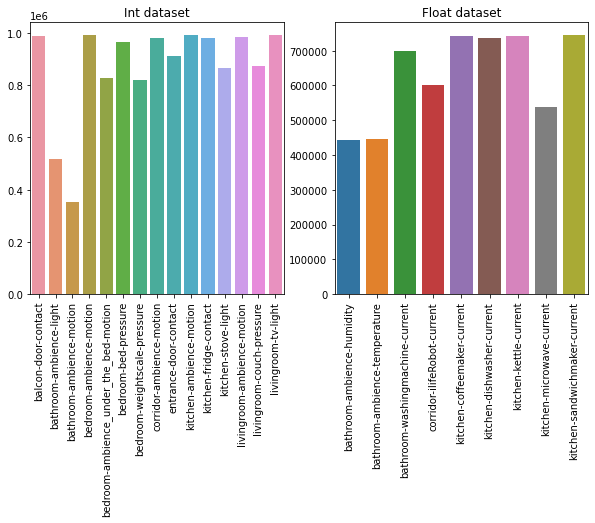

In [11]:
data_samples_plot('float_sensor_compressed', 'int_sensor_compressed')

In [5]:
def cast_columns(df, value_type):
    df = df.withColumn("month",df.month.cast('int'))
    df = df.withColumn("date",df.date.cast('int'))
    df = df.withColumn("value",df.value.cast(value_type))
    df = df.withColumn("hour",df.hour.cast('int'))
    df = df.withColumn("minute",df.minute.cast('int'))
    df = df.withColumn("weekday",df.weekday.cast('int'))
    return df

In [12]:
df = spark.read.csv('int_sensor_compressed/bedroom-bed-pressure.csv', header=True)

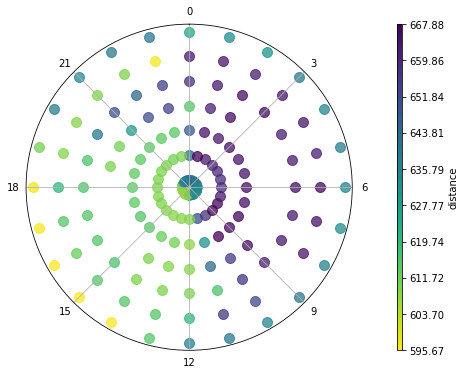

In [13]:
spiral_week(df, 12)

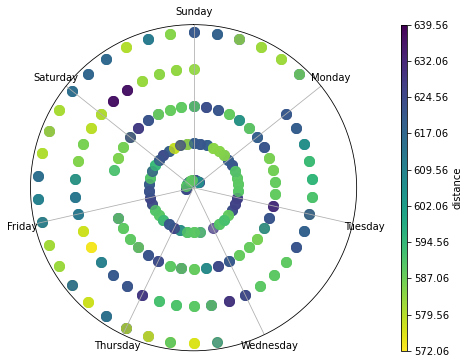

In [14]:
spiral_month(df, 5)

In [15]:
df = spark.read.csv('int_sensor_compressed/livingroom-ambience-motion.csv', header=True)

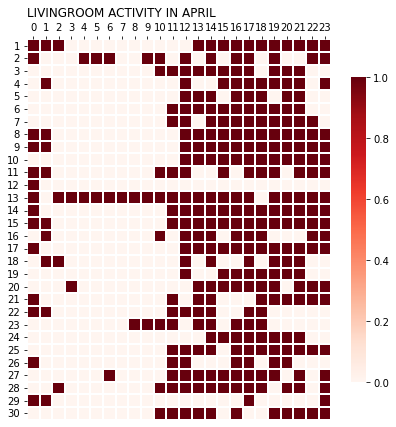

In [19]:
plt_heatmap('livingroom',df, 'April')